# HyPyP Demonstration Notebook

Authors : Guillaume Dumas, Anaël Ayrolles, Florence Brun

Date : 2022-11-03

This notebook demonstrates the basic functionalities of the [HyPyP](https://github.com/ppsp-team/HyPyP/tree/master) library for hyperscanning EEG analysis. 

In this notebook we:
- **Load libraries** for core operations, data science, visualization, and EEG analysis (using MNE).
- **Set analysis parameters** such as frequency bands.
- **Load and preprocess data** (including ICA correction and autoreject) for two participants.
- **Perform analyses** such as power spectral density (PSD) estimation and connectivity analysis.
- **Run statistical tests** (parametric and non-parametric cluster-based permutations) on the computed data.
- **Visualize** the results with sensor maps and connectivity projections in both 2D and 3D.

The expected outputs are cleaned EEG epochs, PSD values, connectivity matrices, statistical test results, and visualizations that help interpret inter- and intra-brain connectivity.

## Load useful libs

### Core

In [2]:
import io
from copy import copy
from collections import OrderedDict
import requests
import tempfile  # For creating temporary files

### Data science

In [3]:
import numpy as np
import scipy

### Visualization

In [4]:
import matplotlib.pyplot as plt

### MNE

In [5]:
import mne

### HyPyP

In [6]:
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

## Setting Analysis Parameters

We define the frequency bands used in the study. Here we use two bands within the Alpha range. We also use an `OrderedDict` to preserve the order of the bands.

In [7]:
# Define frequency bands as a dictionary
freq_bands = {
    'Alpha-Low': [7.5, 11],
    'Alpha-High': [11.5, 13]
}

# Convert to an OrderedDict to keep the defined order
freq_bands = OrderedDict(freq_bands)
print('Frequency bands:', freq_bands)

Frequency bands: OrderedDict({'Alpha-Low': [7.5, 11], 'Alpha-High': [11.5, 13]})


## Loading Data

In this section we download the EEG datasets for two participants, convert them to MNE Epochs, and equalize the number of epochs across participants. 

The function `get_data` downloads a dataset from a given URL and saves it to a temporary file with an MNE-compatible filename.

In [8]:
# Template URL for downloading participant data
URL_TEMPLATE = "https://github.com/ppsp-team/HyPyP/blob/master/data/participant{}-epo.fif?raw=true"

def get_data(idx):
    """
    Download EEG data for a given participant index and save it to a temporary file.
    
    Parameters:
        idx (int): Participant index number.
    
    Returns:
        str: File path of the temporary file containing the EEG data.
    """
    
    # Format the URL with the participant index
    url = URL_TEMPLATE.format(idx)
    
    # Download the data
    response = requests.get(url)
    
    # Save the content to a temporary file with the suffix '-epo.fif'
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix="-epo.fif")
    temp_file.write(response.content)
    temp_file.close()
    
    return temp_file.name

# Load epochs for two participants using MNE
epo1 = mne.read_epochs(
    get_data(1),
    preload=True,
) 

epo2 = mne.read_epochs(
    get_data(2),
    preload=True,
)

Reading /var/folders/ms/k8yj5dhd6sx6y_flq_dnm2zh0000gn/T/tmpmv3k8w2s-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading /var/folders/ms/k8yj5dhd6sx6y_flq_dnm2zh0000gn/T/tmpkwzov5db-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [9]:
# Equalize the number of epochs between participants
mne.epochs.equalize_epoch_counts([epo1, epo2])

# Define sampling frequency from the first participant's data
sampling_rate = epo1.info['sfreq']
print('Sampling rate:', sampling_rate)

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

## Preprocessing Epochs

### ICA Correction

We perform Independent Component Analysis (ICA) on the data from both participants to identify and remove artefactual components. First, we compute the ICA using the HyPyP function `ICA_fit` and then choose the relevant components for artefact rejection using `ICA_choice_comp`.

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': np.float64(0.00010129807784293706)}
0 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 1.4s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': np.float64(4.747409473367548e-05)}
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT10', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'TP10', 'O1']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10']
    Rejecting  epoch based on EEG : ['O1']
4 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 1.7s.


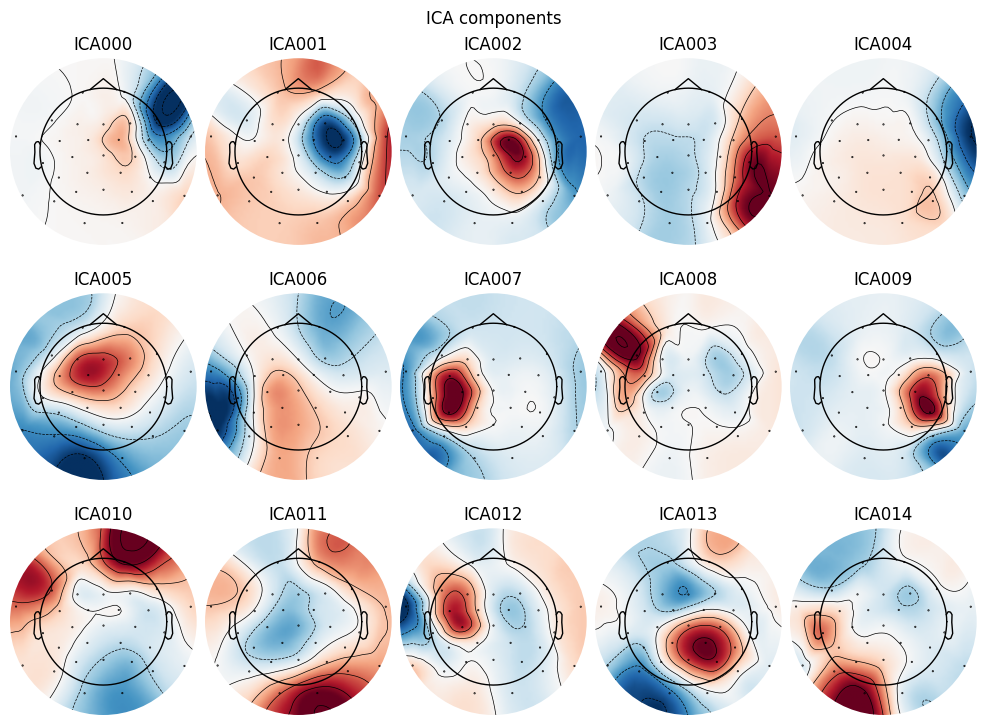

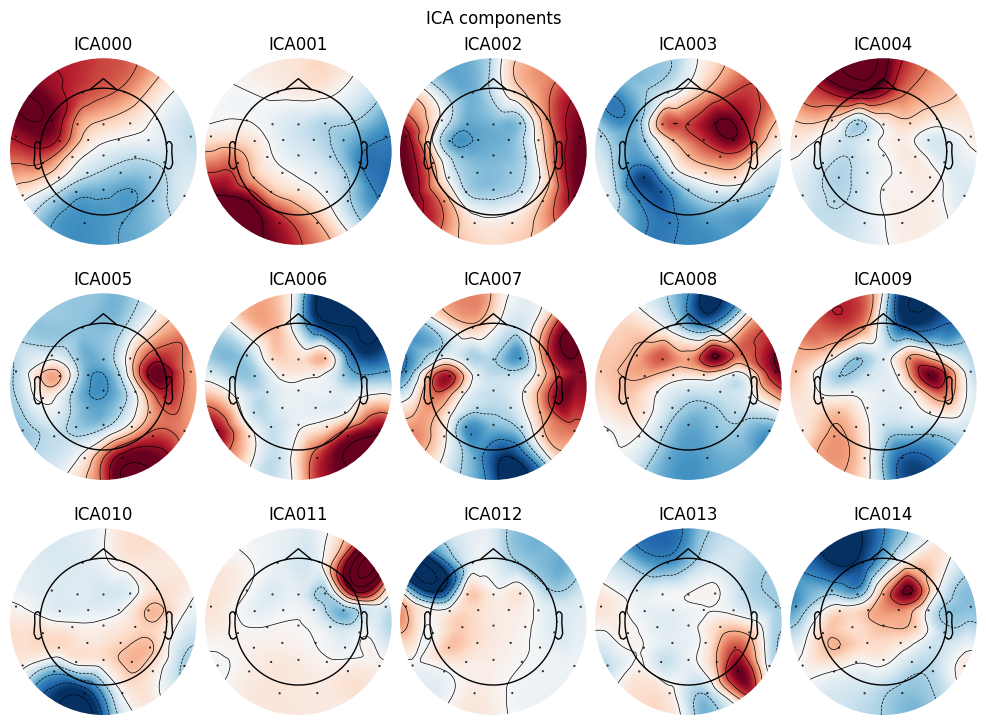

Which participant ICA do you want to use as a template for artifact rejection? Index begins at zero. (If you do not want to apply ICA on your data, do not enter nothing and press enter.) 1
Which IC do you want to use as a template? Index begins at zero. (If you did not choose a participant number at first question, then do not enter nothing and press enter again to not apply ICA on your data) 10


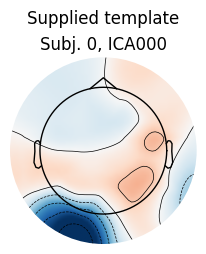

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


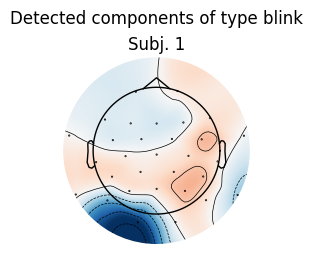

[{'blink': []}, {'blink': [np.int64(10)]}]
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components
ICA correction completed.


In [10]:
# Compute ICA for each participant with 15 components
icas = prep.ICA_fit([
    epo1, epo2
],
    n_components=15,
    method='infomax',
    fit_params=dict(extended=True),
    random_state=42
)

# Select the relevant independent components for artefact rejection
cleaned_epochs_ICA = prep.ICA_choice_comp(icas, [epo1, epo2])
print('ICA correction completed.')

Selecting relevant Independant Components for artefact rejection on one participant, that will be transpose to the other participant and removing them for both.

You can also use the mne-icalabel to automatically detect the not brain related components. Since this library depends on machine learning frameworks with complicated dependancies, we did not include it in the base requirements of HyPyP. If you want to test this automated approach of ICA annotation, just install it using ```pip install mne-icalabel``` and use the function below:

```python
from mne_icalabel import label_components

def ICA_autocorrect(icas: list, epochs: list, verbose: bool = False) -> list:
    """
    Automatically detect the ICA components that are not brain related and remove them.

    Arguments:
        icas: list of Independent Components for each participant (IC are MNE
          objects).
        epochs: list of 2 Epochs objects (for each participant). Epochs_S1
          and Epochs_S2 correspond to a condition and can result from the
          concatenation of Epochs from different experimental realisations
          of the condition.
          Epochs are MNE objects: data are stored in an array of shape
          (n_epochs, n_channels, n_times) and parameters information is
          stored in a disctionnary.
        verbose: option to plot data before and after ICA correction, 
          boolean, set to False by default. 

    Returns:
        cleaned_epochs_ICA: list of 2 cleaned Epochs for each participant
          (the non-brain related IC have been removed from the signal).
    """

    cleaned_epochs_ICA = []
    for ica, epoch in zip(icas, epochs):
        ica_with_labels_fitted = label_components(epoch, ica, method="iclabel")
        ica_with_labels_component_detected = ica_with_labels_fitted["labels"]
        # Remove non-brain components (take only brain components for each subject)
        excluded_idx_components = [idx for idx, label in enumerate(ica_with_labels_component_detected) if label not in ["brain"]]
        cleaned_epoch_ICA = mne.Epochs.copy(epoch)
        cleaned_epoch_ICA.info['bads'] = []
        ica.apply(cleaned_epoch_ICA, exclude=excluded_idx_components)
        cleaned_epoch_ICA.info['bads'] = copy.deepcopy(epoch.info['bads'])
        cleaned_epochs_ICA.append(cleaned_epoch_ICA)

        if verbose:
            epoch.plot(title='Before ICA correction', show=True)
            cleaned_epoch_ICA.plot(title='After ICA correction',show=True)
    return cleaned_epochs_ICA

cleaned_epochs_ICA = ICA_autocorrect(icas, [epo1, epo2], verbose=True)
```

### Autoreject

In this cell, we apply the local AutoReject algorithm using HyPyP. This step automatically rejects or interpolates bad epochs/channels while ensuring that the same channels/epochs are removed across participants. Verbose output provides a before/after comparison.

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20


  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20


  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
22.22222222222222 percent of bad epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


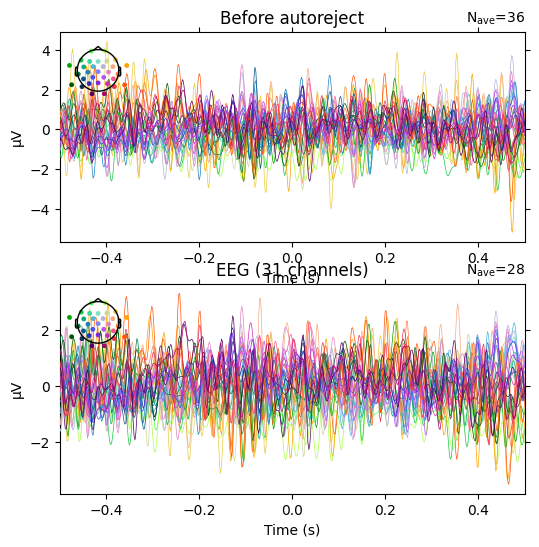

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

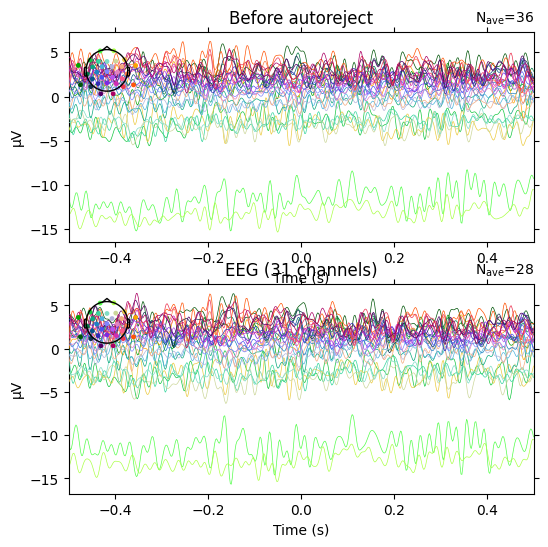

AutoReject completed.


<Figure size 640x480 with 0 Axes>

In [11]:
# Apply local AutoReject on the ICA-cleaned epochs
cleaned_epochs_AR, dic_AR = prep.AR_local(
    cleaned_epochs_ICA,
    strategy="union",
    threshold=50.0,
    verbose=True
)
print('AutoReject completed.')

### Picking Preprocessed Epochs

After cleaning, we separate the preprocessed epochs for each participant for further analysis.

In [12]:
# Assign cleaned epochs to individual participant variables
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]
print('Preprocessed epochs for both participants are ready.')

Preprocessed epochs for both participants are ready.


## Analysing Data: Welch Power Spectral Density (PSD)

Here we compute the PSD for each participant in the Alpha-Low band using the HyPyP `analyses.pow` function. The PSD values are averaged across epochs.

In [13]:
# Compute PSD for participant 1 in the Alpha-Low band
psd1 = analyses.pow(
    preproc_S1,
    fmin=7.5,
    fmax=11,
    n_fft=1000,
    n_per_seg=1000,
    epochs_average=True
)

# Compute PSD for participant 2 in the Alpha-Low band
psd2 = analyses.pow(
    preproc_S2,
    fmin=7.5,
    fmax=11,
    n_fft=1000,
    n_per_seg=1000,
    epochs_average=True
)

# Combine PSD data into a single array
data_psd = np.array([psd1.psd, psd2.psd])
print('PSD analysis completed.')

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
PSD analysis completed.


## Connectivity Analysis

In this section we compute brain connectivity metrics. 

1. We first compute the analytic signal per frequency band using `analyses.compute_freq_bands`.
2. Then, we compute connectivity (using the 'ccorr' mode) and average across epochs.
3. We slice the resulting connectivity matrices to extract both inter-brain (between participants) and intra-brain (within a participant) connectivity values.
4. A Z-score normalization is performed for illustration purposes.

In [14]:
# Prepare data for connectivity analysis (combine both participants)
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []

# Compute the analytic signal in each frequency band
complex_signal = analyses.compute_freq_bands(
    data_inter,
    sampling_rate,
    freq_bands,
    filter_length=int(sampling_rate),  # Adjust filter length based on sampling rate
    l_trans_bandwidth=5.0,  # Reduced transition bandwidth
    h_trans_bandwidth=5.0
)

# Compute connectivity using cross-correlation ('ccorr') and average across epochs
result = analyses.compute_sync(complex_signal, mode='ccorr', epochs_average=True)

# Determine the number of channels
n_ch = len(epo1.info['ch_names'])

# Slice the connectivity matrix to get inter-brain connectivity in the Alpha-Low band
alpha_low, alpha_high = result[:, 0:n_ch, n_ch:2*n_ch]

# For further analysis, choose the Alpha-Low band values
values = alpha_low

# Compute a Z-score normalized connectivity matrix
C = (values - np.mean(values[:])) / np.std(values[:])

# Process intra-brain connectivity for each participant
for i in [0, 1]:
    # Slice intra-brain connectivity matrix
    alpha_low, alpha_high = result[:, (i * n_ch):((i + 1) * n_ch), (i * n_ch): ((i + 1) * n_ch)]
    values_intra = alpha_low
    
    # Remove self-connections
    values_intra -= np.diag(np.diag(values_intra))
    
    # Compute Z-score normalization for intra connectivity
    C_intra = (values_intra - np.mean(values_intra[:])) / np.std(values_intra[:])
    result_intra.append(C_intra)

print('Connectivity analysis completed.')

Connectivity analysis completed.


## Statistical Analyses

We perform several statistical tests on the computed PSD and connectivity data. These include:

- A parametric permutation t-test on the PSD values.
- Non-parametric cluster-based permutation tests for both PSD and connectivity data.

#### 1/ MNE test without any correction
This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension


In [15]:
# Compute mean PSD values for each channel across epochs for both participants
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)

# Combine the means into a single array for the t-test
X = np.array([psd1_mean, psd2_mean])

# Perform permutation t-test (using MNE) without correction for multiple comparisons
T_obs, p_values, H0 = mne.stats.permutation_t_test(
    X=X,
    n_permutations=5000,
    tail=0,
    n_jobs=1
)
print('Permutation t-test completed.')

# Alternatively, compute statistical conditions using HyPyP's statsCond function
statsCondTuple = stats.statsCond(
    data=data_psd,
    epochs=preproc_S1,
    n_permutations=5000,
    alpha=0.05
)
print('Statistical condition tuple computed.')

Permuting 1 times (exact test)...
Permutation t-test completed.
Permuting 1 times (exact test)...
Statistical condition tuple computed.


### Non-parametric Cluster-Based Permutations

Here, we create a priori connectivity matrices based on sensor positions and then perform cluster-based permutation tests. 

In this example, we create two fake groups (by replicating each participant's PSD data with added noise) and run the permutation test.

In [16]:
# Create connectivity matrix for a priori sensor connectivity using participant 1's sensor layout
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

# Create two fake groups by replicating the PSD data and adding a small noise
noise_level = 1e-6  # Small noise to break exact duplicates
data_group = [
    np.array([psd1.psd + np.random.normal(0, noise_level, psd1.psd.shape) for _ in range(3)]),
    np.array([psd2.psd + np.random.normal(0, noise_level, psd2.psd.shape) for _ in range(3)])
]

# Perform non-parametric cluster-based permutation test on the fake groups
statscondCluster = stats.statscondCluster(
    data=data_group,
    freqs_mean=psd1.freq_list,
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
    tail=1,
    n_permutations=5000,
    alpha=0.05
)
print('Cluster-based permutation test for PSD completed.')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Using a threshold of 7.708647
stat_fun(H1): min=4.101536517167135e-06 max=29.41881334871197
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Cluster-based permutation test for PSD completed.


### Comparing Intra-Brain Connectivity Between Participants

We now compute a connectivity matrix for intra-brain connectivity and perform a cluster-based permutation test comparing the two participants. 

Again, we generate two fake groups by replicating each participant’s intra-brain connectivity data and adding noise.

Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [17]:
# Create connectivity matrix for intra-brain connectivity
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1,
    freqs_mean=np.arange(7.5, 11),
    draw=False
)

ch_con = con_matrixTuple.ch_con

# Create fake groups for intra-brain connectivity analysis
Alpha_Low = [
    np.array([
        result_intra[0] + np.random.normal(0, noise_level, result_intra[0].shape),
        result_intra[0] + np.random.normal(0, noise_level, result_intra[0].shape)
    ]),
    np.array([
        result_intra[1] + np.random.normal(0, noise_level, result_intra[1].shape),
        result_intra[1] + np.random.normal(0, noise_level, result_intra[1].shape)
    ])
]

# Run cluster-based permutation test for intra-brain connectivity
statscondCluster_intra = stats.statscondCluster(
    data=Alpha_Low,
    freqs_mean=np.arange(7.5, 11),
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
    tail=1,
    n_permutations=5000,
    alpha=0.05
)
print('Intra-brain connectivity cluster test completed.')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Using a threshold of 18.512821
stat_fun(H1): min=1976482.0554561717 max=inf
Running initial clustering …
Found 1 cluster


/Users/blackstar/Library/Caches/pypoetry/virtualenvs/hypyp-ypSSj9M0-py3.12/lib/python3.12/site-packages/mne/stats/parametric.py:171: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Intra-brain connectivity cluster test completed.


### Comparing Inter-Brain Connectivity to Random Signal

Finally, we compare inter-brain connectivity values to a random signal. In this case, no a priori connectivity matrix is used between the two participants. We again create fake groups and run the permutation test.

In [18]:
# Create fake groups for inter-brain connectivity analysis
data = [
    np.array([
        values, 
        values + np.random.normal(0, 1e-6, values.shape)
    ]), 
    np.array([
        result_intra[0], 
        result_intra[0] + np.random.normal(0, 1e-6, result_intra[0].shape)
    ])
]

print(len(data[0][0]), len(data[0][1]), len(data[1][0]), len(data[1][1]))


# Run cluster-based permutation test for inter-brain connectivity without connectivity priors
statscondCluster = stats.statscondCluster(
    data=data,
    freqs_mean=np.linspace(7.5, 11, data[0].shape[-1]),
    ch_con_freq=None,
    tail=0,
    n_permutations=5000,
    alpha=0.05
)
print('Inter-brain connectivity cluster test completed.')

31 31 31 31
stat_fun(H1): min=4883533.9892763095 max=828084908035748.4
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Inter-brain connectivity cluster test completed.


## Visualization

In this final section, we visualize the statistical results and connectivity maps. We use HyPyP visualization functions to:

- Plot sensor-level T-values for all sensors and for only significant sensors.
- Visualize inter-brain connectivity on 2D and 3D head models.
- Visualize intra-brain connectivity for each participant in both 2D and 3D.

Note: We manually specify bad channels for visualization purposes.

In [19]:
# Plot sensor-level T-values using the t-statistics computed earlier
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs,
    epochs=preproc_S1
)
print('Sensor-level T-values plotted.')

Sensor-level T-values plotted.


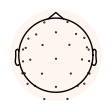

Significant sensors T-values plotted.


In [20]:
# Plot only the T-values for sensors that are statistically significant
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot,
    epochs=preproc_S1
)
print('Significant sensors T-values plotted.')

### Visulization of inter-brain links projected
on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [21]:
epo1.info['bads'] = ['F8', 'Fp2', 'Cz', 'O2']
epo2.info['bads'] = ['F7', 'O1']

### Visualisation of brain connectivity in 2D and 3D
Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, it is calculated specifically for the dyad, and therefore does not allow comparability between different dyads.

#### Visualization of inter-brain connectivity in 2D

Inter-brain Hilbert-based connectivity

In [ ]:
viz.viz_2D_topomap_inter(epo1, epo2, C, threshold='auto', steps=10, lab=True)

#### Visualization of inter-brain connectivity in 3D

Inter-brain Hilbert-based connectivity


In [ ]:
viz.viz_3D_inter(epo1, epo2, C, threshold='auto', steps=10, lab=False)
print('3D inter-brain connectivity visualization completed.')

#### Visualization of intra-brain connectivity in 2D

Intra-brain Hilbert-based connectivity

In [ ]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

print('2D intra-brain connectivity map plotted.')

#### Visualization of intra-brain connectivity in 3D

Intra-brain Hilbert-based connectivity

In [ ]:
viz.viz_3D_intra(epo1, epo2,
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False)

print('3D intra-brain connectivity visualization completed.')